In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

In [3]:
orders = pd.read_csv(
    "../data/part1-dataset.csv", parse_dates=["created_date", "first_created_at"]
    )

In [4]:
orders.head(10)

,created_date,deliverey_category_id,weekday,first_created_at,time_bucket,total_distance,sum_product,source_latitude,source_longitude,destination_latitude,destination_longitude,final_customer_fare,final_biker_fare,first_customer_fare,hyper_ack
0,2022-07-25,0,1,2022-07-25 15:34:22+00:00,120,4.4780,17,30.604658,53.503632,31.602938,54.477932,300000,300000,250000,1
1,2022-07-23,0,6,2022-07-23 10:21:51+00:00,89,3.3368,5,37.306400,60.657444,38.305122,61.677757,470000,470000,230000,1
2,2022-10-16,0,7,2022-10-16 10:27:08+00:00,83,0.4854,1,33.629711,52.633621,34.628998,53.630806,160000,160000,160000,1
3,2022-10-25,4,2,2022-10-25 09:57:54+00:00,80,8.1736,1,33.672604,52.686855,34.654903,53.704929,950000,530000,530000,1
4,2022-08-01,0,1,2022-08-01 08:48:47+00:00,79,2.4995,1,36.820545,51.996281,37.827084,52.974762,450000,360000,230000,1
5,2022-08-02,0,2,2022-08-02 12:26:30+00:00,101,2.3040,3,31.273190,58.074833,32.285353,59.085854,270000,270000,270000,1
6,2022-08-21,0,7,2022-08-21 15:48:34+00:00,121,1.3930,4,37.561237,54.072170,38.556301,55.076195,400000,180000,180000,0
7,2022-09-08,0,4,2022-09-08 08:29:30+00:00,77,1.4002,4,37.361897,60.506786,38.355972,61.503471,170000,170000,170000,1
8,2022-11-11,0,5,2022-11-11 17:38:51+00:00,126,1.4832,10,37.372936,60.477482,38.368992,61.470581,340000,170000,170000,0
9,2022-10-17,0,1,2022-10-17 09:25:59+00:00,77,4.4246,2,35.624802,51.876247,36.643002,52.876999,360000,270000,240000,0


## Exploratory Data Analysis

In [5]:
orders = orders.assign(first_created_at_hour = orders["first_created_at"].dt.hour)

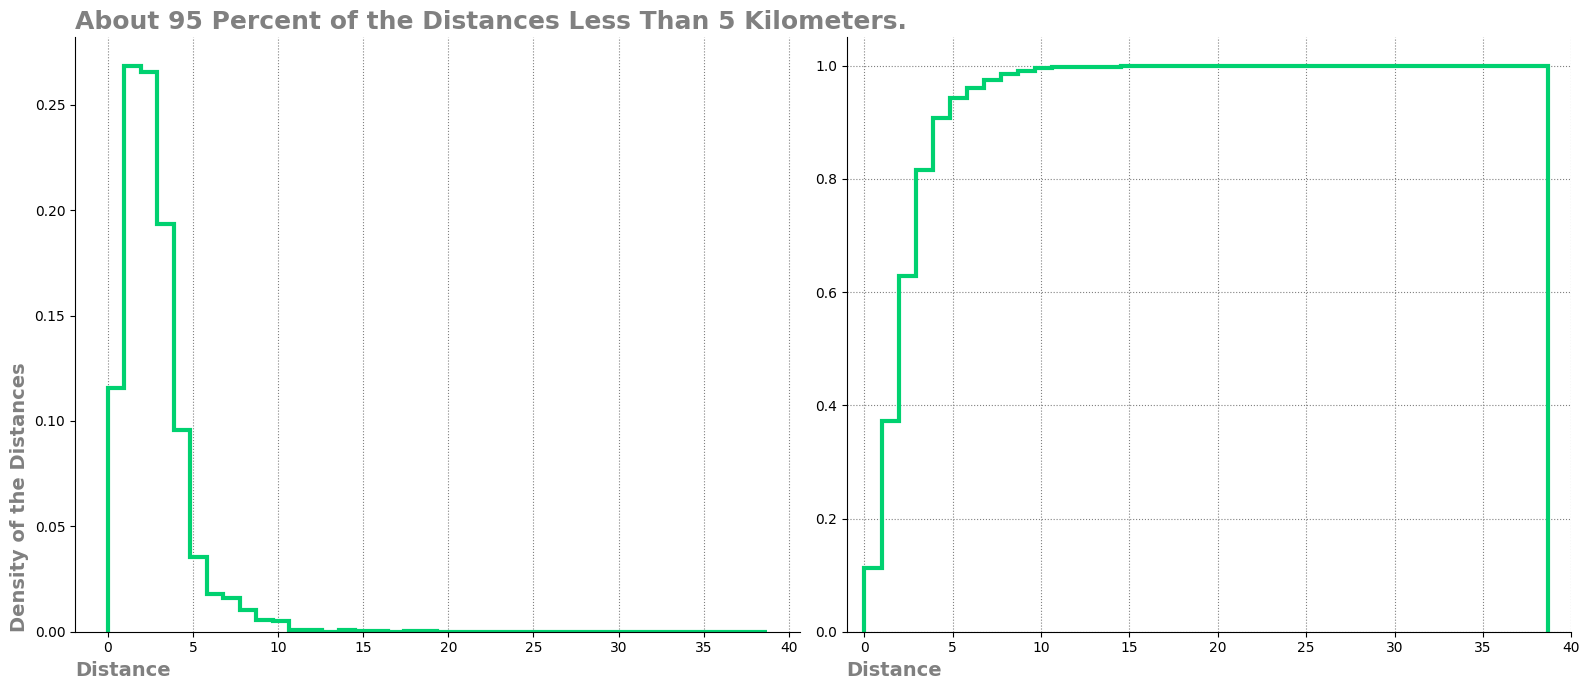

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].hist(
    orders['total_distance'],
    color = "#00D170",
    bins = 40,
    density = True,
    histtype = "step",
    lw = 3,
)

ax[0].spines[["right", "top"]].set_visible(False)
ax[0].set_ylabel(
    "Density of the Distances",
    loc = "bottom",
    weight = "bold",
    fontsize = 14,
    color = "gray"
)
ax[0].set_xlabel("Distance", loc = "left", weight = "bold",fontsize = 14, color = "gray")
ax[0].set_title(
    "About 95 Percent of the Distances Less Than 5 Kilometers.",
    weight = "bold",
    color = "gray",
    fontsize = 18,
    loc = "left"
)
ax[0].grid(True, which='major', axis='x', linestyle=':', color='gray')

ax[1].hist(
    orders["total_distance"],
    color="#00D170",
    bins=40,
    density=True,
    cumulative=True,
    histtype="step",
    lw=3,
)

ax[1].spines[["right", "top"]].set_visible(False)

ax[1].set_xlabel("Distance", loc="left", weight="bold", fontsize=14, color="gray")

ax[1].set_ylim(0, 1.05)
ax[1].set_xlim(-1, 40)  

ax[1].grid(True, which='major', axis='both', linestyle=':', color='gray')

plt.tight_layout()
plt.show()

In [9]:
normal_hyper_ack_status = (
    orders.groupby(['first_created_at_hour', 'hyper_ack'], as_index=False)
    .agg(
        total_order = ('hyper_ack', 'count'),
    )
    .pivot_table(
        index = "first_created_at_hour", columns= "hyper_ack", values="total_order"
    )
    .reset_index()
    .rename(columns={0: "normal", 1: "hyper_ack"})
    .fillna(0)
    .assign(total_hour_order=lambda df: df['normal'] + df['hyper_ack'])
    .assign(share_hyper_ack= lambda df: df['hyper_ack'] / df['total_hour_order'])
    .query("total_hour_order != 1")
)

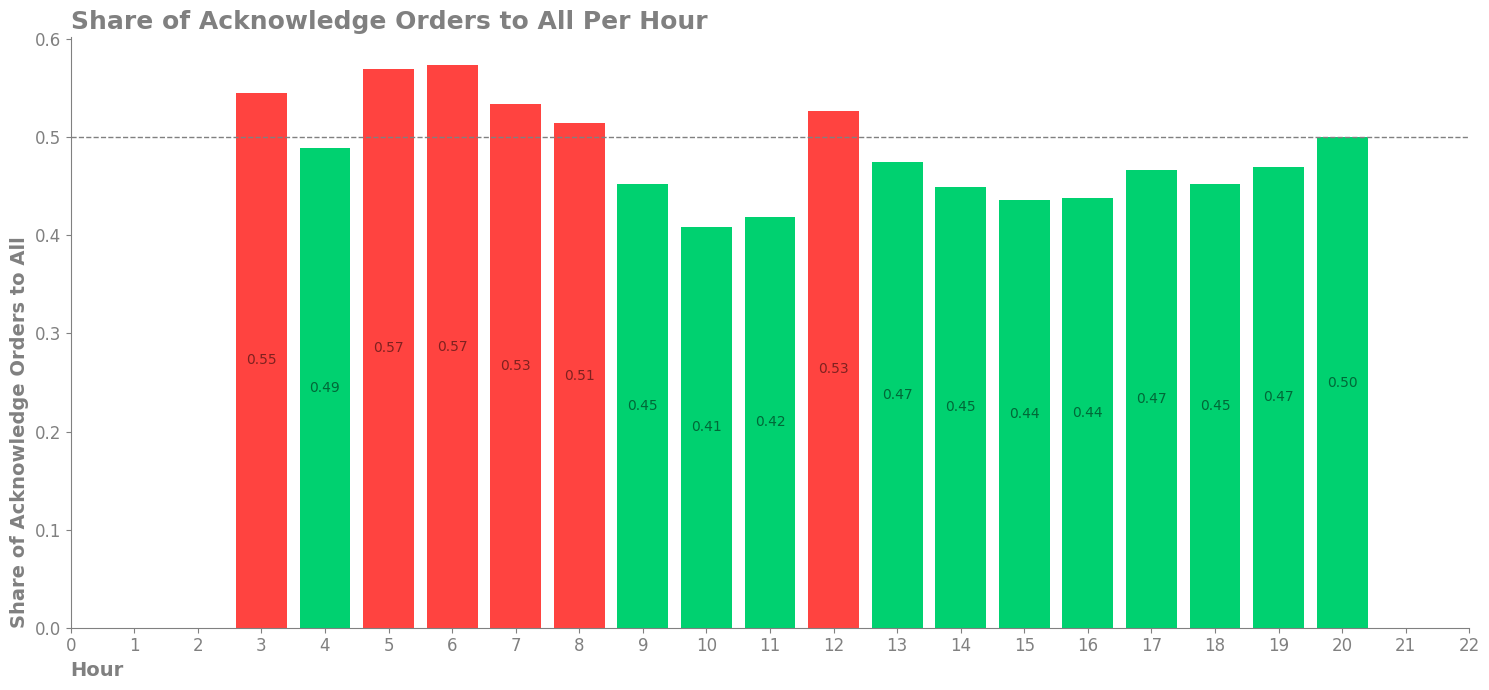

In [17]:
fig, ax = plt.subplots(figsize= (15, 7), sharex=True)

rect_share = ax.bar(
    normal_hyper_ack_status["first_created_at_hour"],
    normal_hyper_ack_status["share_hyper_ack"],
    color = np.where(
        normal_hyper_ack_status["share_hyper_ack"].gt(0.5), "#FF4340", "#00D170"
    )
)
ax.bar_label(rect_share, label_type = "center", fmt = "%.2f", alpha= 0.5)
ax.set_xticks(range(0, 23))
ax.spines[["top", "right"]].set_visible(False)   
ax.spines[["bottom", "left"]].set_color("gray")
ax.tick_params(axis="x", colors="gray", labelsize="large")
ax.tick_params(axis="y", colors="gray", labelsize="large")

ax.set_xlabel("Hour", loc= "left", weight="bold", fontsize = 14, color= "gray")

ax.set_ylabel(
    "Share of Acknowledge Orders to All",
    loc = "bottom",
    weight= "bold",
    fontsize =14,
    color= "gray"
)
ax.axhline(y=0.5, color= "gray", linestyle= "--", linewidth = 1)

ax.set_title(
    "Share of Acknowledge Orders to All Per Hour",
    loc = "left",
    weight= "bold",
    fontsize =18,
    color= "gray"
)

plt.tight_layout()
plt.show()
